# **Lab experience #10 (SOLUTION): Time-series clustering**

This 10th lab session aims **to use clustering over time-series**, another common type of data you may encounter in your future works. This lab session refers to Prof. Stella's lectures on k-means++ clustering, but also includes the notion of [Dynamic Time Warping (DTW)](https://www.youtube.com/watch?v=_K1OsqCicBY&ab_channel=ThalesSehnK%C3%B6rting).

In this lab session, you will **re-use code already developed in the previous labs**, and make use of the package [tslearn](https://tslearn.readthedocs.io/en/stable/), a python package based on sklearn and scipy that has been developed, on purpose, for time-series.

The **number of clusters** (```K```) as well as the **true labels** (```labels```) are given. Anyway, try to use them only at the end for validating your methods.


_Guiding slides_ are available on Moodle.




```
Suggested notation:

*   N = number of time-series available
*   T = number of samples in each time-series
*   X = NxT dataset
*   labels = true labels
*   Use red plots for Euclidean, blue plots for DTW, black for truth
*   Use suffix "_E" for Euclidean-based solutions (e.g., the number of clusters = K_E)
*   Use suffix "_D" for DTW-based solutions (e.g., the number of clusters = K_D)

```


In [ ]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
# ! pip install tslearn              # only the first time you run this code
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics.cluster import adjusted_rand_score

# **Step 1:** Load the dataset and visual inspection

In [ ]:
# Load the dataset
K = 3
X      = np.load('Dataset_Lab11.npy')
labels = np.load('TRUElabels_Lab11.npy')
[N, T] = np.shape(X)
# T is the number of samples in each time-series
# N is the number of time-series available
print([N, T])

[50, 275]


Notes on the dataset:

1. The time-series have been previously pre-processed to have zero-mean and unit variance (using TimeSeriesScalerMeanVariance).
2. Additionally, the time-series have been subsampled to have a smaller number of samples (using TimeSeriesResampler).

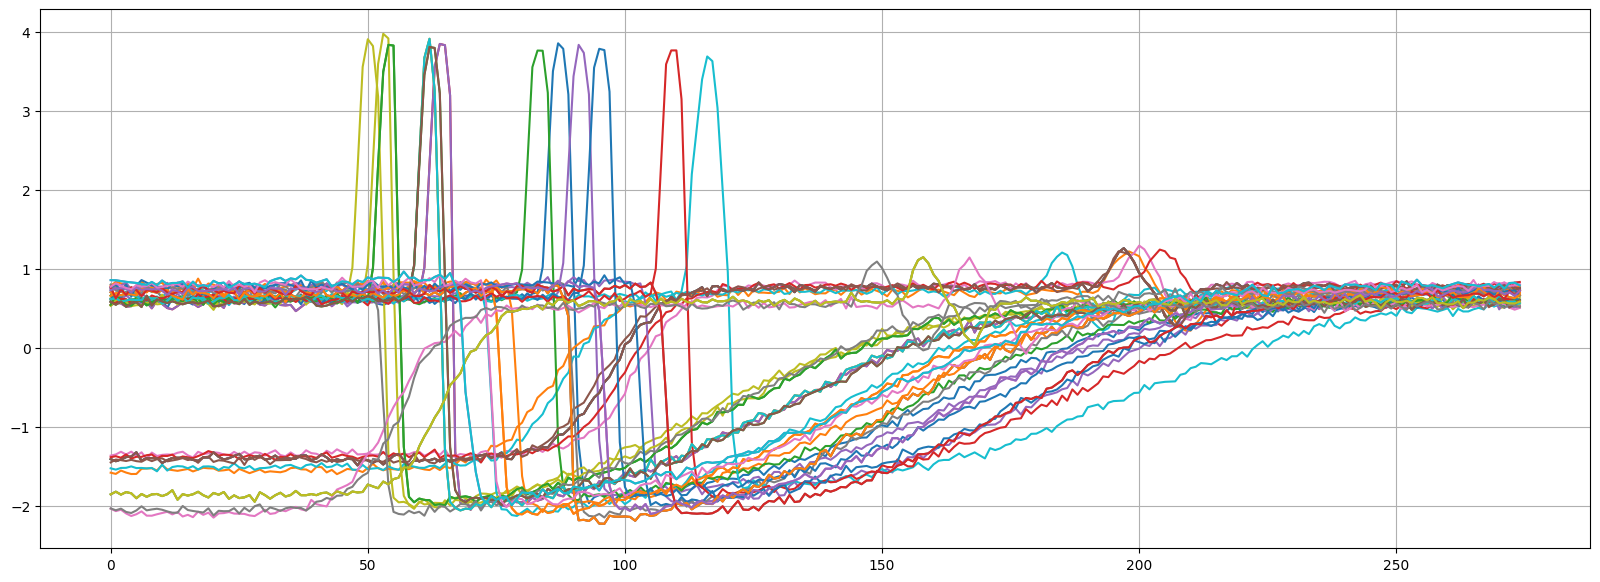

In [ ]:
# Visualize all time-series in the dataset
fig1 = plt.figure(figsize=(20,7))
plt.plot(X.T)
plt.grid()

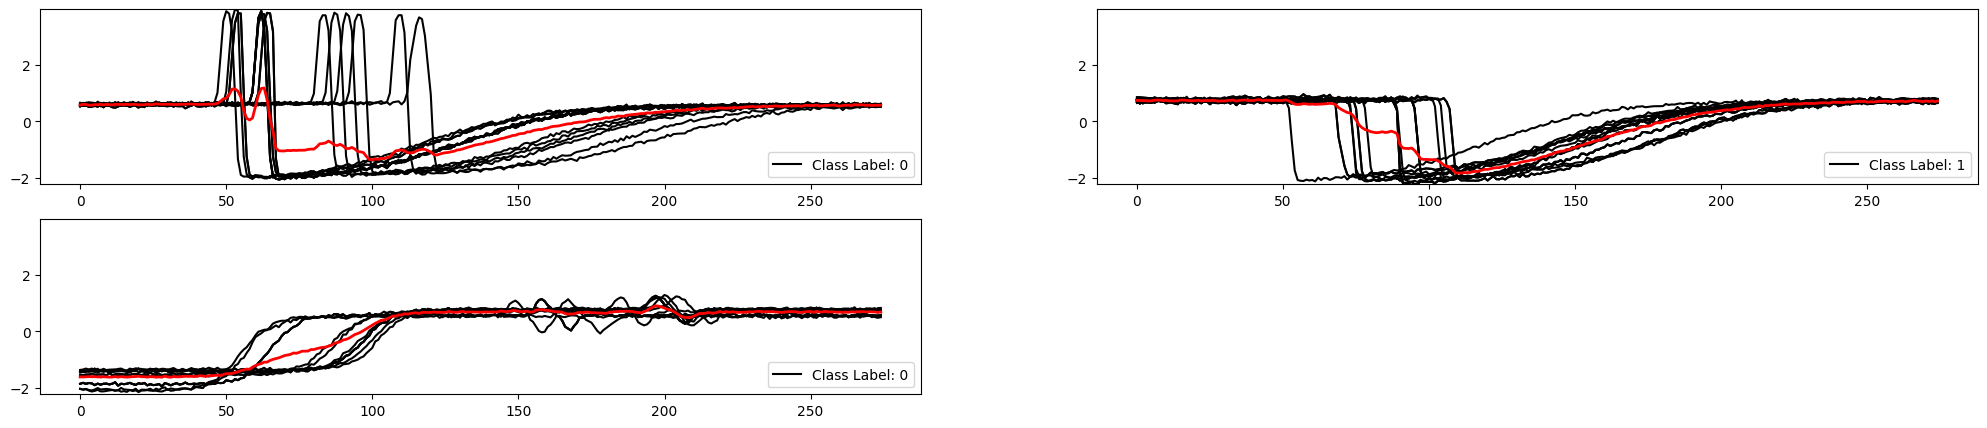

In [ ]:
# Visualize the time-series with the true labels. One subplot for each cluster.
# Take the chance to compute the true cluster centers as average of the time-series in each cluster.
true_cluster_centers = np.zeros((3,T))

fig2 = plt.figure(figsize=(25,5))
for yi in range(3):
    plt.subplot(2, 2, yi + 1)
    c=0
    for xx in X[labels == yi]:
        plt.plot(xx.ravel(), "k-")
        c += 1
        true_cluster_centers[yi,:] = true_cluster_centers[yi,:] + xx
    true_cluster_centers[yi,:] = true_cluster_centers[yi,:]/c
    plt.plot(true_cluster_centers[yi,:], "r-", lw=2)
    plt.ylim([np.min(X),np.max(X)])
    plt.legend(['Class Label: %d' % yi], loc=4)  #corrected Giulia on August, 25th
plt.show()

**Comment:** Averaging (physiologically) shifted and scaled time-series is still very frequent in the healthcare domain, but you realized how distorted the average time-series can be.

# **Step 2:** Time-series k-means clustering

See documentation [tslearn](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans).

To cluster the time-series, you need to use a metric distance. _tslearn_ provides **three different types of distances for time-series**. You are required to use the euclidean and the DTW-based.
Among the parameters of the function, you have:

```
metric{“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
```

Also, in case you use ```dtw```, you need to set the ```max_iter_barycenter``` (or leave it to the default).

Take a look to the documentation, you will find a number of other parameters that are the same as you have already set during lab#4 (about k-means clustering).

In both cases, you need to use the **elbow method**.

## **Step 2a:** Euclidean distance

1.  Implement the elbow method using **euclidean metric**
2.  Define ```K_E``` the optimal number of clusters
3.  Run k-means++ with ```K_E``` clusters, find labels, cluster centers, and the inertia
4   Plot the time-series in one plot with ```K_E``` subplots, each one including the time-series of a different cluster.

In [ ]:
# Elbow method (Euclidean distance)
inertia_values = np.zeros(9)
NINIT = 10
MAXITER = 300
RANDOMSTATEVALUE = None

# implement the elbow method using k-means++. Use method: TimeSeriesKMeans
i=0
for k in range(2, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='euclidean', init='k-means++', n_init=NINIT, max_iter=MAXITER, tol=0.0001, random_state=RANDOMSTATEVALUE, verbose=False).fit(X)
    inertia_values[i] = kmeans.inertia_
    i=i+1

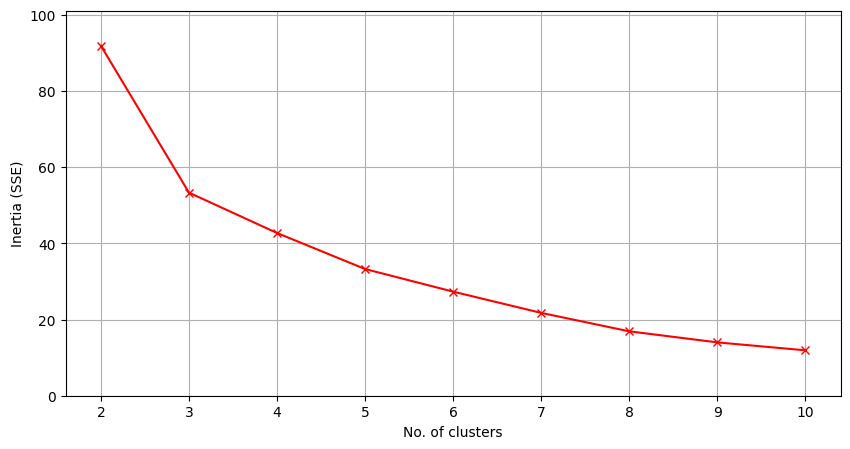

In [ ]:
# Plot for the elbow method
fig3 = plt.figure('[Euclidean distance] K-means++: elbow method', figsize=(10,5))
plt.plot(range(2,11), inertia_values, color='r', marker="x", linestyle="-")
plt.xticks(np.arange(2, 11, step=1))
plt.xlabel('No. of clusters')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.grid()
# plt.show()

In [ ]:
# Estimate the number of clusters (elbow method)
K_E = 3
SSE_E = inertia_values[K_E-2]
print('The best number of clusters is K=%d with an SSE=%.2f '% (K_E, SSE_E))

kmeans_E = TimeSeriesKMeans(n_clusters=K_E, metric='euclidean', init='k-means++', n_init=NINIT, max_iter=MAXITER, tol=0.0001, random_state=RANDOMSTATEVALUE, verbose=False).fit(X)
kmeans_E_labels = kmeans_E.labels_

The best number of clusters is K=3 with an SSE=53.30 


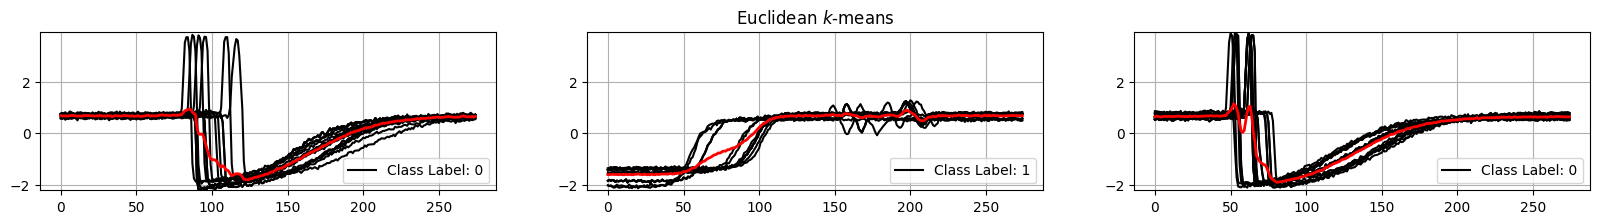

In [ ]:
fig4 = plt.figure(figsize=(20,7))
for k in range(K_E):
    plt.subplot(3, 3, k + 1)
    for xx in X[kmeans_E_labels == k]:
        plt.plot(xx.ravel(), "k-")
    plt.plot(kmeans_E.cluster_centers_[k].ravel(), "r-", lw=2)
    plt.ylim([np.min(X),np.max(X)])
    plt.grid()
    plt.legend(['Class Label: %d' % (labels[k])], loc=4)
    if k == 1:
        plt.title("Euclidean $k$-means")

## **Step 2b:** DTW-based distance

1.  Implement the elbow method using **dynamic time warping (DTW)**
2.  Define ```K_D``` the optimal number of clusters
3.  Run k-means++ with ```K_D``` clusters, find labels, cluster centers, and the inertia
4   Plot the time-series in one plot with ```K_D``` subplots, each one including the time-series of a different cluster.

_Note: this method might take **long time**. Use lower values of NINIT and MAXITER to run this block in a short time, still preserving robust results (in the future, you can increase the value of these parameters and run the method again)._


```
Suggested values:
NINIT = 1
MAXITER = 10
```

In [ ]:
# Elbow method (DTW)
inertia_values = np.zeros(9)
NINIT = 1
MAXITER = 10
RANDOMSTATEVALUE = None

i=0
for k in range(2, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw', init='k-means++', n_init=NINIT, max_iter=MAXITER, tol=0.0001, max_iter_barycenter=50, random_state=RANDOMSTATEVALUE, verbose=False).fit(X)
    inertia_values[i] = kmeans.inertia_
    i=i+1

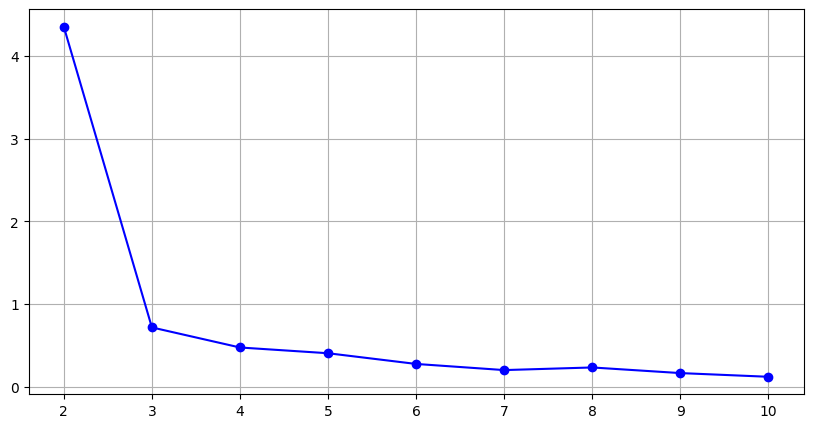

In [ ]:
# Plot for the elbow method
fig5 = plt.figure('[DTW] K-means++: elbow method', figsize=(10,5))
# plt.figure(fig3)
plt.plot(range(2,11), inertia_values, color='b', marker="o", linestyle="-")
plt.xticks(np.arange(2, 11, step=1))
# plt.ylim([0, 20])
plt.grid()
plt.show()

In [ ]:
# Estimate the number of clusters (elbow method)
K_D = 3
SSE_D = inertia_values[K_D-2]
print('The best number of clusters is K=%d with an SSE=%.2f '% (K_D, SSE_D))

kmeans_D = TimeSeriesKMeans(n_clusters=K_D, metric='dtw', init='k-means++', n_init=NINIT, max_iter=MAXITER, tol=0.0001, random_state=RANDOMSTATEVALUE, verbose=False).fit(X)
kmeans_D_labels = kmeans_D.labels_

The best number of clusters is K=3 with an SSE=0.72 


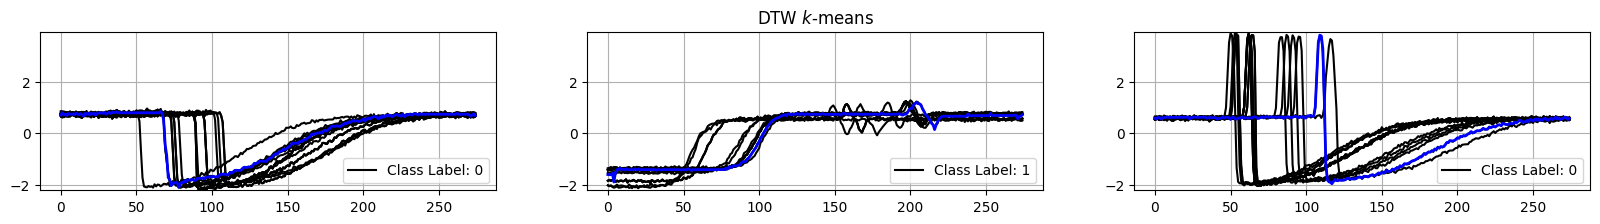

In [ ]:
fig6 = plt.figure(figsize=(20,7))
for k in range(K_D):
    plt.subplot(3, 3, k + 1)
    for xx in X[kmeans_D_labels == k]:
        plt.plot(xx.ravel(), "k-")
    plt.plot(kmeans_D.cluster_centers_[k].ravel(), "b-", lw=2)
    plt.ylim([np.min(X),np.max(X)])
    plt.legend(['Class Label: %d' % (labels[k])], loc=4)
    plt.grid()
    if k == 1:
        plt.title("DTW $k$-means")

**Comment:** You may appreciate the much more consistency of the cluster's centroids in this method.

# **Step 3:** compare results with the true labels
This time you are provided with the true labels (```labels```), so you can check the performance of the two methods.

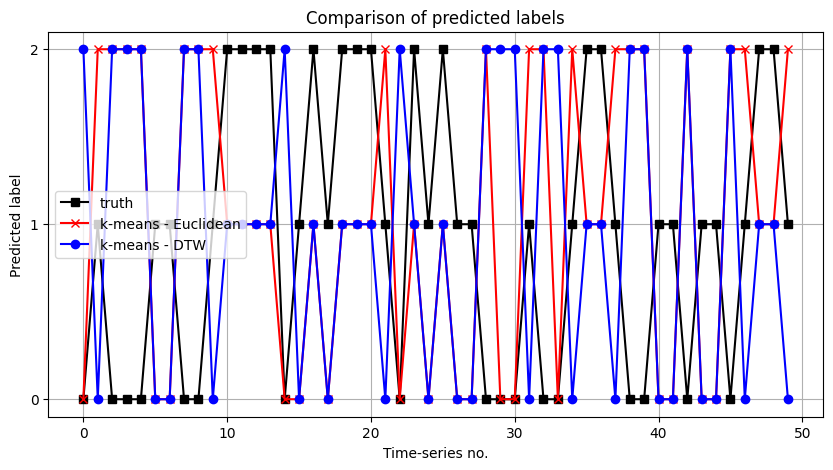

In [ ]:
# Before compute Rand index, I would suggest you to visually inspecting the match between the labels assigned by the two different clustering solutions
# using a simple line plot
y1 = kmeans_E_labels   # predicted labels from k-means++ with euclidean distance
y2 = kmeans_D_labels   # predicted labels from k-means++ with DTW distance
# true labels already loaded

fig7 = plt.figure('Comparison of predicted labels', figsize=(10,5))
plt.plot(labels, color='k', marker="s", label='truth')
plt.plot(y1,     color='r', marker="x", label='k-means - Euclidean')
plt.plot(y2,     color='b', marker="o", label='k-means - DTW')
plt.xlabel('Time-series no.')
plt.yticks(np.arange(0,np.max([K_E, K_D])))
plt.ylabel('Predicted label')
plt.title("Comparison of predicted labels")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
R1 = adjusted_rand_score(labels, y1)
R2 = adjusted_rand_score(labels, y2)
R3 = adjusted_rand_score(y1, y2)

print('Match between truth and Euclidean k-means++ (Rand index): %.2f' % np.round(R1,2))
print('Match between truth and DTW k-means++ (Rand index): %.2f' % np.round(R2,2))
print('Match between Euclidean k-means++ and DTW k-means++ (Rand index): %.2f.' % np.round(R3,2))

Match between truth and Euclidean k-means++ (Rand index): 0.43
Match between truth and DTW k-means++ (Rand index): 1.00
Match between Euclidean k-means++ and DTW k-means++ (Rand index): 0.43.


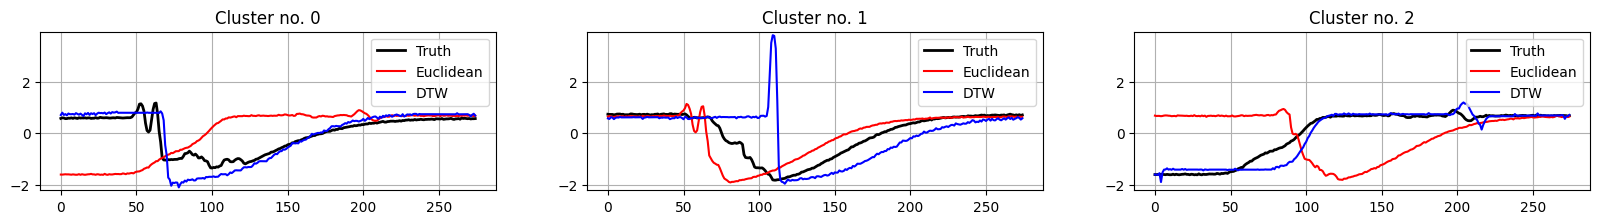

In [ ]:
# Plot the average time-series of each cluster and compare the average from truth, euclidean-kmeans, DTW-kmeans
fig8 = plt.figure(figsize=(20,7))

# Re-organize labels
# Euclidean-1 corresponds to truth-0
# DTW-2 corresponds to truth-0
# ...
# ...

plt.subplot(3, 3, 1)
plt.plot(true_cluster_centers[0].ravel(), "k-", lw=2)
plt.plot(kmeans_E.cluster_centers_[1].ravel(), "r-")
plt.plot(kmeans_D.cluster_centers_[0].ravel(), "b-")
plt.ylim([np.min(X),np.max(X)])
plt.legend(['Truth','Euclidean','DTW'], loc=1)
plt.grid()
plt.title('Cluster no. 0')

plt.subplot(3, 3, 2)
plt.plot(true_cluster_centers[1].ravel(), "k-", lw=2)
plt.plot(kmeans_E.cluster_centers_[2].ravel(), "r-")
plt.plot(kmeans_D.cluster_centers_[2].ravel(), "b-")
plt.ylim([np.min(X),np.max(X)])
plt.legend(['Truth','Euclidean','DTW'], loc=1)
plt.grid()
plt.title('Cluster no. 1')

plt.subplot(3, 3, 3)
plt.plot(true_cluster_centers[2].ravel(), "k-", lw=2)
plt.plot(kmeans_E.cluster_centers_[0].ravel(), "r-")
plt.plot(kmeans_D.cluster_centers_[1].ravel(), "b-")
plt.ylim([np.min(X),np.max(X)])
plt.legend(['Truth','Euclidean','DTW'], loc=1)
plt.grid()
plt.title('Cluster no. 2')

plt.show()

**Note** that the truth displayed is only exemplary and not a robust representative of all time-series of its cluster.

**Step 4:** White additive noise-corrupted time-series and repeat clustering.

In [ ]:
# Artificially add white additive gaussian noise (AWGN)
SNRdB = -3 #[dB]

# Transform the dB value into linear scale
SNR = 10**(SNRdB/10)

# Initialize
X_corrupted = np.zeros((X.shape))

# Apply corruption to all time-series
for n in range(X.shape[0]):
  sigma = np.sqrt( (np.var(X[n,:]) + np.mean(X[n,:])**2)/SNR )
  noise = sigma*np.random.randn(T)
  # print( 'SNR = %.2f dB' % (10*np.log10( np.sum(X[n,:]**2)/np.sum(noise**2))).round(2) )    # if you want to check that SNR is (roughly) the one decided
  X_corrupted[n,:] = X[n,:] + noise

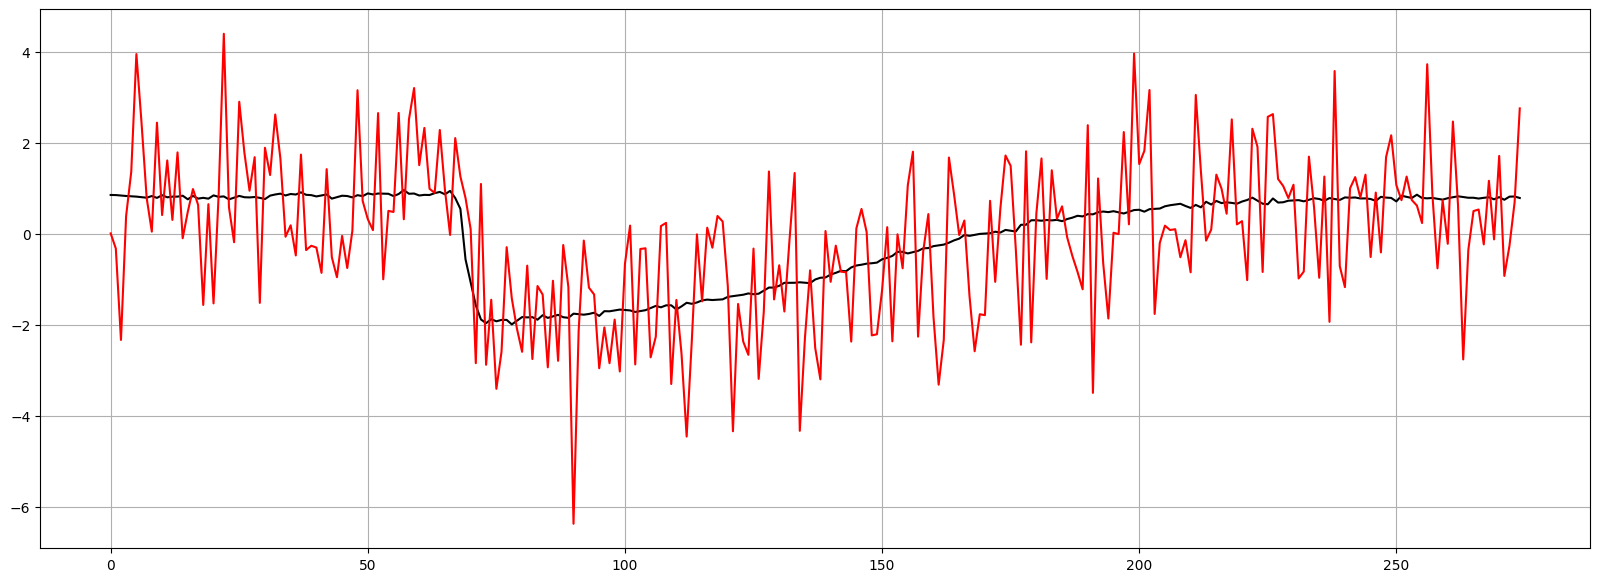

In [ ]:
# Visualize one time-series (black) and its corrupted version (red)
fig9 = plt.figure(figsize=(20,7))
plt.plot(X[n,:],'k-')
plt.plot(X_corrupted[n,:], "r-")
plt.grid()

REPEAT STEPS 2-3

1. Euclidean method (elbow, no. clusters, cluster centers computation, visualization)
2. DTW method (elbow, no. clusters, cluster centers computation, visualization)
3. Comparison

You can compare the results for SNR = -3dB (i.e., the power of noise is double than that of the signal) and for SNR = 20dB (i.e., almost no noise is corrupting the signal).

In [ ]:
# Elbow method (Euclidean distance)
inertia_values_corr = np.zeros(9)
NINIT = 10
MAXITER = 300
RANDOMSTATEVALUE = None

# implement the elbow method using k-means++. Use method: TimeSeriesKMeans
i=0
for k in range(2, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k,
                              metric='euclidean',
                              init='k-means++',
                              n_init=NINIT,
                              max_iter=MAXITER,
                              tol=0.0001,
                              random_state=RANDOMSTATEVALUE,
                              verbose=False).fit(X_corrupted)
    inertia_values_corr[i] = kmeans.inertia_
    i=i+1

# print(inertia_values_corr)

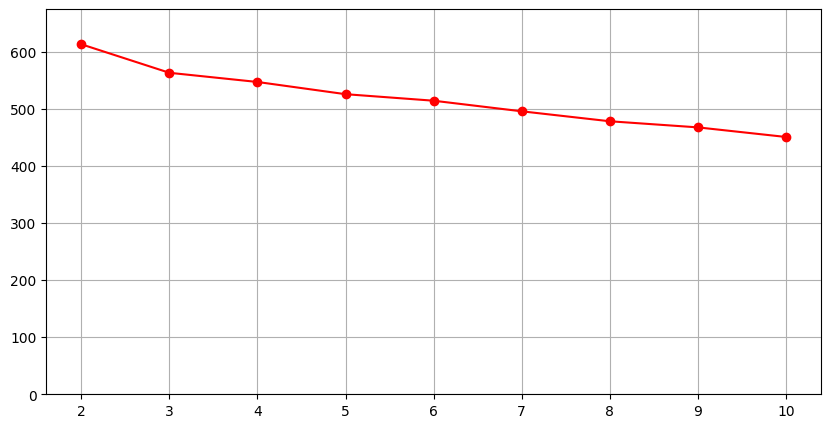

In [ ]:
# Plot for the elbow method (Euclidean)
fig10 = plt.figure('[Euclidean] K-means++ on corrupted signal: elbow method', figsize=(10,5))
plt.plot(range(2,11), inertia_values_corr, color='r', marker="o", linestyle="-")
plt.xticks(np.arange(2, 11, step=1))
plt.ylim(0, np.max(inertia_values_corr)*1.1)
plt.grid()
plt.show()

In [ ]:
# Estimate the number of clusters (Euclidean)
K_E = 3
SSE_E = inertia_values_corr[K_E-2]
kmeans_E_corr        = TimeSeriesKMeans(n_clusters=K_E,
                                        metric='euclidean',
                                        init='k-means++',
                                        n_init=NINIT,
                                        max_iter=MAXITER,
                                        tol=0.0001,
                                        random_state=RANDOMSTATEVALUE,
                                        verbose=False).fit(X_corrupted)
kmeans_E_labels_corr = kmeans_E_corr.labels_

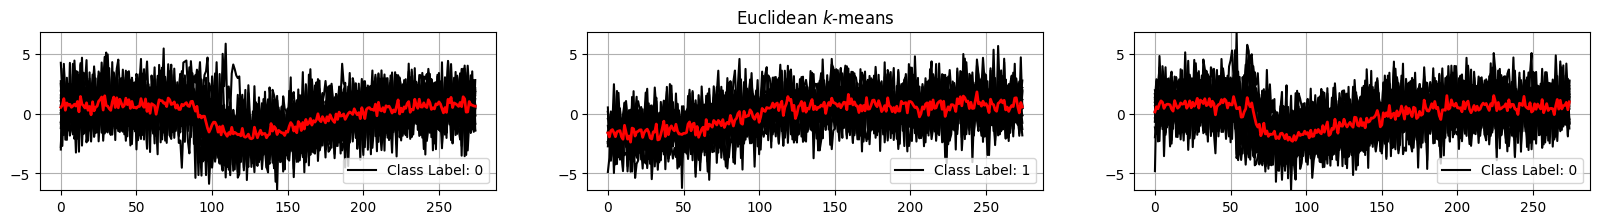

In [ ]:
# Centroids (Euclidean)
fig11 = plt.figure(figsize=(20,7))
for k in range(K_E):
    plt.subplot(3, 3, k + 1)
    for xx in X_corrupted[kmeans_E_labels_corr == k]:
        plt.plot(xx.ravel(), "k-")
    plt.plot(kmeans_E_corr.cluster_centers_[k].ravel(), "r-", lw=2)
    plt.ylim([np.min(X_corrupted),np.max(X_corrupted)])
    plt.legend(['Class Label: %d' % (labels[k])], loc=4)
    plt.grid()
    if k == 1:
        plt.title("Euclidean $k$-means")

**Note:** this means that you should accept an SNR level higher than a certain value (e.g., ...) and a proper number of clusters, otherwise k-means++ might fail.

In [ ]:
# Elbow method (DTW)
inertia_values_corr = np.zeros(9)
NINIT = 1
MAXITER = 10
RANDOMSTATEVALUE = None

i=0
for k in range(2, 11):
    kmeans = TimeSeriesKMeans(n_clusters=k,
                              metric='dtw',
                              init='k-means++',
                              n_init=NINIT,
                              max_iter=MAXITER,
                              tol=0.0001,
                              max_iter_barycenter=50,
                              random_state=RANDOMSTATEVALUE,
                              verbose=False).fit(X_corrupted)
    inertia_values_corr[i] = kmeans.inertia_
    i=i+1

# print(inertia_values_corr)

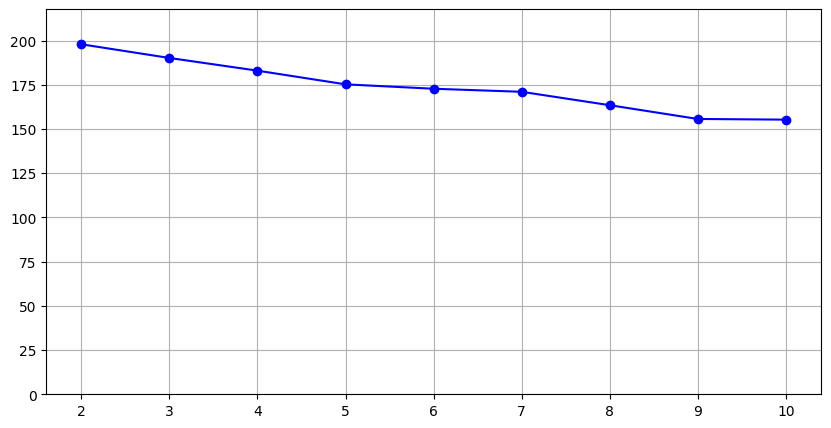

In [ ]:
# Plot for the elbow method (DTW)
fig20 = plt.figure('[DTW] K-means++ on corrupted signal: elbow method', figsize=(10,5))
plt.plot(range(2,11), inertia_values_corr, color='b', marker="o", linestyle="-")
plt.xticks(np.arange(2, 11, step=1))
plt.ylim(0, np.max(inertia_values_corr)*1.1)
plt.grid()
plt.show()

In [ ]:
# Estimate the number of clusters (DTW)
K_D = 3
SSE_D = inertia_values[K_D-2]

kmeans_D_corr = TimeSeriesKMeans(n_clusters=K_D,
                            metric='dtw',
                            init='k-means++',
                            n_init=NINIT,
                            max_iter=MAXITER,
                            tol=0.0001,
                            random_state=RANDOMSTATEVALUE,
                            verbose=False).fit(X_corrupted)

kmeans_D_labels_corr = kmeans_D_corr.labels_

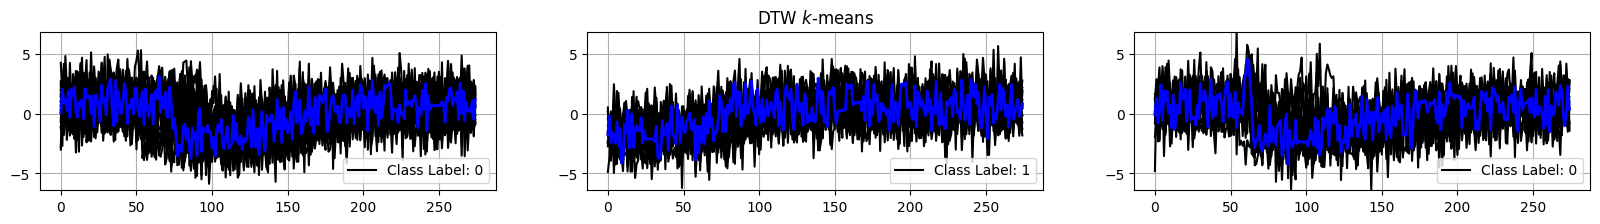

In [ ]:
# Centroids (DTW)
fig21 = plt.figure(figsize=(20,7))
for k in range(K_D):
    plt.subplot(3, 3, k + 1)
    for xx in X_corrupted[kmeans_D_labels_corr == k]:
        plt.plot(xx.ravel(), "k-")
    plt.plot(kmeans_D_corr.cluster_centers_[k].ravel(), "b-", lw=2)
    plt.ylim([np.min(X_corrupted),np.max(X_corrupted)])
    plt.legend(['Class Label: %d' % (labels[k])], loc=4)
    plt.grid()
    if k == 1:
        plt.title("DTW $k$-means")

**Note:** You can observe that SSE increases when SNR decreases, as expected. However, Euclidean might be better than DTW in case of very noisy signals to find proper clusters and better centroids. This could be also expected, given that the noise (by construction) is a additive white noise, i.e., it is uniformly spread all over the signals and in the time using simple additive overlapping. This means that the Euclidean method might work better as it averages, sample by sample, in the time, while the DTW method struggles to find the best synchroization when the samples are too noisy.
In a real applications, in these situations, an additional pre-processing step is needed to lower the noise to further apply DTW.